SETUP

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")   # Run only if necessary

from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Check if GPU is available

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

DATASET

In [5]:
# Dataset generator

n = 10
m = 5
hop = 1/1200
input_dim   = 30 * n
pred_dim    = 0.25
shift       = pred_dim
batch_size  = 16
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch']
                )

In [ ]:
Data.Train.element_spec

In [8]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

MODEL

In [16]:
# Loss functions

# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss = tf.keras.losses.MeanAbsoluteError()

# Metrics

# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [10]:
# norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
# x_ds = Data.Train.map(lambda x, y: x)
# norm.adapt(x_ds)

In [23]:
# Define model here

class EncDec(tf.keras.Model):
    def __init__(self, enc_units, dec_units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.enc_units = enc_units
        self.dec_units = dec_units

        # Encoder cells
        self.encoder_cells = [tf.keras.layers.LSTMCell(units) for units in self.enc_units]
        self.encoder_stacked = tf.keras.layers.StackedRNNCells(self.encoder_cells)
        self.encoder_rnn = tf.keras.layers.RNN(self.encoder_stacked, return_state=True)
#         self.enc_dense = tf.keras.layers.Dense(INPUT_DIM[-1])

        # Decoder cells
        self.decoder_cells = [tf.keras.layers.LSTMCell(units) for units in self.dec_units]
        self.dense = tf.keras.layers.Dense(OUTPUT_DIM[-1])

    def warmup(self, inputs):
        
        out = self.encoder_rnn(inputs)
#         x = self.enc_dense(out[0])
        x = inputs[:,-1:,0]
        
        return x, out[1:]

    def call(self, inputs, training=True):
        
        predictions = []
        
        prediction, states = self.warmup(inputs)

        # Insert the first prediction.
#         predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(0, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            states_ = []
            
            for i in range(0, len(self.decoder_cells)):
                
                x, state = self.decoder_cells[i](x, states=states[i],
                                        training=training)
                states_.append(state)                        
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)
            states = states_

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [ ]:
enc = [256]
dec = [256]
model = EncDec(enc, dec, OUTPUT_DIM[0])

In [24]:
# Compile model
LOSS = MSE_loss
METRICS = [MAPE, MAE]
LR = 1e-3

opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss=LOSS, metrics=METRICS)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1200, 1024)        4210688   
                                                                 
 lstm_7 (LSTM)               (None, 128)               590336    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,801,153
Trainable params: 4,801,153
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Check if model is working and the output shape

for x, y in Data.Train.take(1):
    out = model(x)
    print(out.shape)

(16, 1)


TRAINING

In [26]:
# Defining the required callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,
                                                    mode='min')

checkpoint_filepath = 'models/LSTM_encdec/01/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="models/LSTM_encdec/01/metrics", update_freq=50)

In [ ]:
# Model training

model.fit(Data.Train, epochs=100, validation_data=Data.Val, callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback])

In [ ]:
# Save model
# Uncomment to save model

# model_save_dir = 'models/LSTM/03r/model'

# model.save(model_save_dir)

IMPORTING SAVED MODEL

In [5]:
# Load model

model_dir = 'models/LSTM_encdec/01/model'

model = tf.keras.models.load_model(model_dir)

model.summary()

Model: "enc_dec_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_40 (LSTMCell)     multiple                  266240    
                                                                 
 stacked_rnn_cells_12 (Stack  multiple                 266240    
 edRNNCells)                                                     
                                                                 
 rnn_12 (RNN)                multiple                  266240    
                                                                 
 lstm_cell_41 (LSTMCell)     multiple                  264192    
                                                                 
 dense_14 (Dense)            multiple                  257       
                                                                 
Total params: 530,689
Trainable params: 530,689
Non-trainable params: 0
__________________________________________________

MODEL PERFORMANCE

In [16]:
# Dataset generator for inference

n = 10
m = 5
hop = 0.5
input_dim   = 30 * n
pred_dim    = 30 * n
shift       = pred_dim
batch_size  = 16
Data_inf        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch'],
                out_cols=['roll','heave','pitch']
                )

In [17]:
Data_inf.Val.element_spec

(TensorSpec(shape=(None, 1200, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1200, 3), dtype=tf.float64, name=None))

In [18]:
def ARModel_Inference(x, y, OUT_dim = pred_dim*4, model=model):
    inp1 = x
    true_roll = y[:,:,0]
    pred_roll = []
    for i in range(OUT_dim):
#         wave = y[:,i:i+1,-1:]
#         INPUT = (inp1, wave[:,:,0])
        OUT = model(inp1)
        roll = tf.cast(OUT, tf.float64)
        HnP = y[:,i:i+1,1:3]
        temp = tf.concat([roll, HnP], axis = -1)
        inp1 = tf.concat([inp1[:,1:,:], temp], axis=1)
        pred_roll.append(roll)

    pred_roll = tf.squeeze(tf.stack(pred_roll, axis=1), [-1]) 
    return true_roll, pred_roll


def save_inference(Data_inf, model=model, OUT_dim = pred_dim*4, save_dir=None):
    true_roll = []
    pred_roll = []
    inputs = []
    for x, y in Data_inf:
        t_r, p_r = ARModel_Inference(x, y, OUT_dim = OUT_dim, model=model)
        pred_roll.extend(p_r)
        true_roll.extend(t_r)
        inputs.extend(x)
        
    inputs = np.array(inputs)
    true_roll = np.array(true_roll)
    pred_roll = np.array(pred_roll)
    
    if save_dir is not None:
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        inp_path = save_dir + '/inputs.csv'
        true_path = save_dir + '/true_roll.csv'
        pred_path = save_dir + '/pred_roll.csv'
        
        np.savetxt(inp_path, inputs[:,:,0], delimiter =", ")
        np.savetxt(true_path, true_roll, delimiter =", ")
        np.savetxt(pred_path, pred_roll[:,:,0], delimiter =", ")
        
        
    return inputs, true_roll, pred_roll
    


val_dir = 'models/LSTM_encdec/01/Val'
test_dir = 'models/LSTM_encdec/01/Test'


test_in, test_true, test_pred = save_inference(Data_inf.Test, save_dir=test_dir)
val_in, val_true, val_pred = save_inference(Data_inf.Val, save_dir=val_dir)

KeyboardInterrupt: 

In [19]:
def plot_inference(inputs, true, pred, nos, cut=0.5, units='deg'):
    n = inputs.shape[-1]
    n_plots = len(nos)
    cut_ind = int(n*cut)
    
    fac = 180/np.pi if units=='deg' else 1
    
    plt.figure(figsize=(18, n_plots*5))
    
    w1_end = inputs.shape[1]
    w2_size = true.shape[-1]*cut_ind
    t1 = np.array(range(0, w1_end))*0.25
    t2 = np.array(range(w1_end, w1_end + cut_ind))*0.25
    
    for i, ind in enumerate(nos):
        plt.subplot(n_plots, 1, i+1)
        plt.plot(t1, inputs[ind]*fac, label='Input')
        plt.plot(t2, true[ind,:cut_ind]*fac, label='True_roll')
        plt.plot(t2, pred[ind,:cut_ind]*fac, label='Pred_roll')
        plt.ylabel(f"Roll angle ({units})")
        plt.legend()
    plt.xlabel("Time (s)")    
    plt.show()  

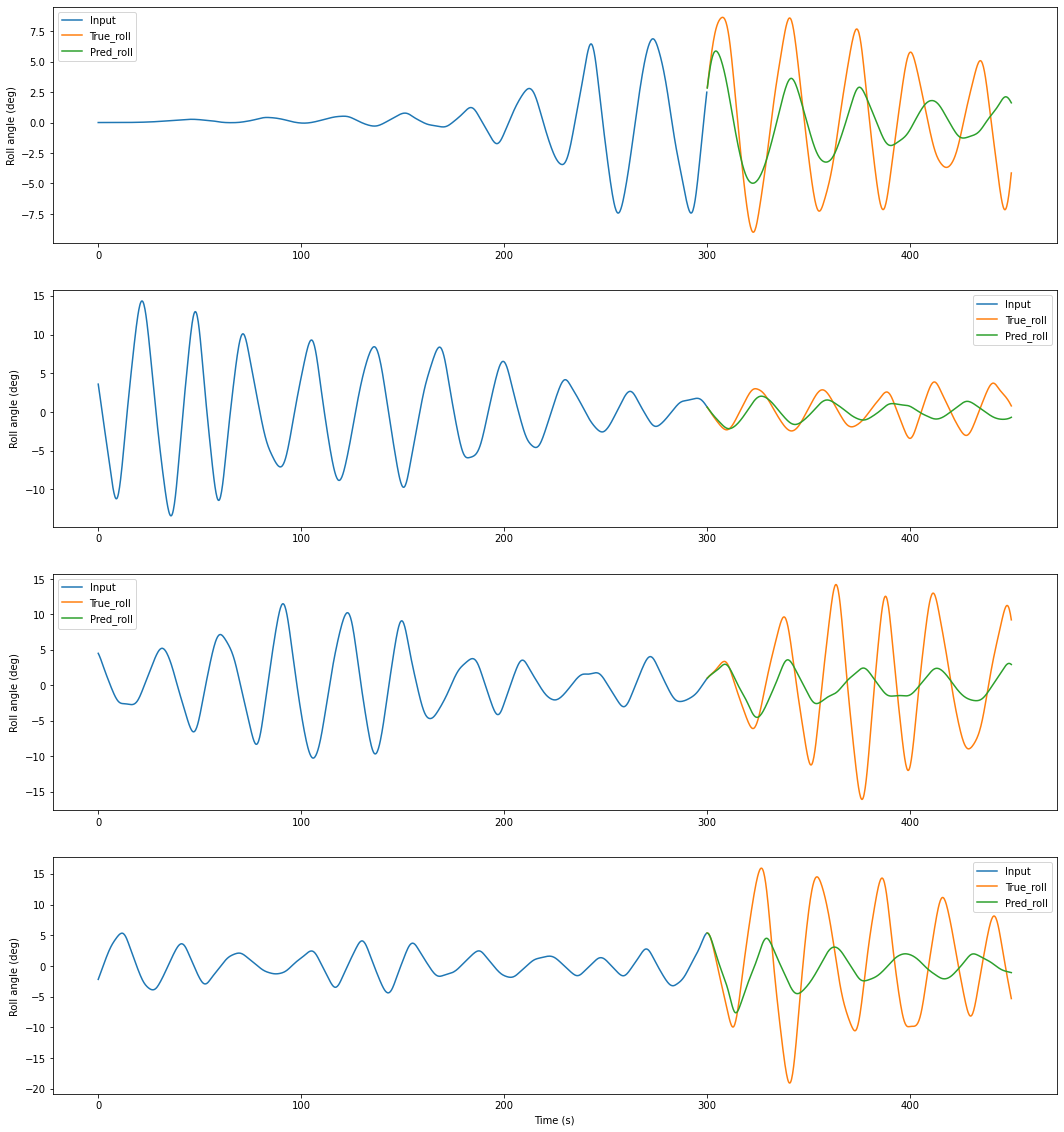

In [21]:
plot_inference(test_in[:,:,0], test_true, test_pred, [0,10,50,100])

In [ ]:
# Evaluate model

val_performance = model.evaluate(Data.Val)
test_performance = model.evaluate(Data.Test)

print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

INFERENCE